In [11]:

# Recurrent Neural Networks Real Estate Price Prediction - Multivariate Time Series

""" In folder /Processed Data, hpi_econo_and_constmaterial_merged_df is the dataframe we will start working with for our ML multivariate prediction model.

Predicting housing prices like financial assets is a complex task given the confluence of a vast number of variable that have a direct influence, positive or negative, on 
real estate prices. Unquantifiable events such as political decisions, economic cycles, market sentiment and the weather all do exert forces on housing prices; plus, many variables
are interdependent which makes statistical modeling difficult when it comes to housing.

We will go with the standard approach:
1_ selecting features
2_ scaling the data of selected features
3_ slicing the data with a sliding window approach
4_ training the model on past data
5_ validating our trained model
6_ making predictions
7_ unscaling predictions to have coherent values.

"""

'\nIn folder /Processed Data, hpi_econo_and_constmaterial_merged_df is the dataframe we will start working with for our ML multivariate prediction model.\n\nPredicting housing prices like financial assets is a complex task given the confluence of a vast number of variable that have a direct influence, positive or negative, on \nreal estate prices. Unquantifiable events such as political decisions, economic cycles, market sentiment and the weather all do exert forces on housing prices; plus, many variables\nare interdependent which makes statistical modeling difficult when it comes to housing.\n\nWe will go with the standard approach:\n1_ selecting features\n2_ scaling the data of selected features\n3_ slicing the data with a sliding window approach\n4_ training the model on past data\n5_ validating our trained model\n6_ making predictions\n7_ unscaling predictions to have coherent values.\n\n'

In [12]:
# pip install keras

In [32]:
import numpy as np
import pandas as pd
import math

# Visualization and date formatting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

# Date functions
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters

# ML modules / deep learning for RNN
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
# Loading csv in dataframe 

# We will use the hpi_econo_and_constmaterial_merged_df dataframe which includes House prices indexes, Econ data and construction materials Price indexes.

df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\hpi_econo_and_constmaterial_merged_df.csv")

# Storing date column to add to dataframe later
dates = df["REF_DATE"]

#Dropping columns with non-numerical values

df = df.drop(columns="Unnamed: 0", axis = 1)
df = df.drop(columns="REF_DATE.1", axis = 1)
df = df.drop(columns="REF_DATE", axis = 1)


# Finding all columns with NaN values
df.isna().any()

stone_VALUE                       False
crushedStone_VALUE                False
logsbolts_VALUE                   False
ironOres_concentrates_VALUE       False
HPI_nfland_labrador                True
HPI_charlottetown_pei              True
HPI_halifax_ns                     True
HPI_stjohn_fredericton_moncton     True
HPI_quebec_qc                      True
HPI_sherbrooke_qc                  True
HPI_troisriv_qc                    True
HPI_mtl_qc                         True
HPI_ottawa_gatineau_qc             True
HPI_ottawa_gatineau_ont            True
HPI_oshawa_ont                     True
HPI_toronto_ont                    True
HPI_hamilton_ont                   True
HPI_guelph_ont                     True
HPI_london_ont                     True
HPI_windsor_ont                    True
HPI_sudbury_ont                    True
HPI_winnipeg_manitoba              True
HPI_edmonton_alb                   True
HPI_calgary_alb                    True
HPI_victoria_bc                    True


In [34]:
# With nan values in all columns of df 
# Let's fill all NaN cells with mean value of column 

df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

# How replace NaN values one column at the time
# df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())

# Previewing
df.head()

,stone_VALUE,crushedStone_VALUE,logsbolts_VALUE,ironOres_concentrates_VALUE,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,...,HPI_sudbury_ont,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc,Interest_Rate_Central_Bank,CPI_inflation,unemployment_rate
0,6221.6308,5454.0270,7130.6353,9534.4472,37.5,97.493051,76.06122,61.4,34.9,103.114706,...,54.6,29.3,36.5,27.8,206.8,96.1,109.138235,17.00,12.200957,7.4
1,6282.2311,5454.0270,7130.6353,10261.6508,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,55.6,29.7,36.8,28.1,209.1,97.5,109.138235,17.14,12.056738,7.4
2,6403.4317,5494.4272,7231.6358,10201.0505,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,55.6,30.3,36.8,28.6,210.6,97.5,109.138235,16.59,12.676056,7.3
3,6443.8319,5534.8274,7312.4362,8968.8444,37.5,97.493051,76.06122,62.1,35.7,103.114706,...,57.0,30.5,36.9,30.1,210.6,97.7,109.138235,17.40,12.587413,7.1
4,6423.6318,5413.6268,7393.2366,9009.2446,37.7,97.493051,76.06122,63.3,36.1,103.114706,...,57.0,31.1,38.2,30.1,212.4,97.7,109.138235,19.06,12.211982,7.2


In [35]:
# Given columns with long successions of NaN values let's drop these column before building our Model.

# df = df.drop(columns={"HPI_nfland_labrador", "HPI_charlottetown_pei", "HPI_halifax_ns", "HPI_kelowna_bc", "HPI_sherbrooke_qc", "HPI_troisriv_qc", "HPI_ottawa_gatineau_qc", "HPI_oshawa_ont"}, axis = 1)

# Inserting REF_DATE column with data in dates 
df["REF_DATE"] = dates
# Previewing
df.head()

,stone_VALUE,crushedStone_VALUE,logsbolts_VALUE,ironOres_concentrates_VALUE,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,...,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc,Interest_Rate_Central_Bank,CPI_inflation,unemployment_rate,REF_DATE
0,6221.6308,5454.0270,7130.6353,9534.4472,37.5,97.493051,76.06122,61.4,34.9,103.114706,...,29.3,36.5,27.8,206.8,96.1,109.138235,17.00,12.200957,7.4,1981-01
1,6282.2311,5454.0270,7130.6353,10261.6508,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,29.7,36.8,28.1,209.1,97.5,109.138235,17.14,12.056738,7.4,1981-02
2,6403.4317,5494.4272,7231.6358,10201.0505,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,30.3,36.8,28.6,210.6,97.5,109.138235,16.59,12.676056,7.3,1981-03
3,6443.8319,5534.8274,7312.4362,8968.8444,37.5,97.493051,76.06122,62.1,35.7,103.114706,...,30.5,36.9,30.1,210.6,97.7,109.138235,17.40,12.587413,7.1,1981-04
4,6423.6318,5413.6268,7393.2366,9009.2446,37.7,97.493051,76.06122,63.3,36.1,103.114706,...,31.1,38.2,30.1,212.4,97.7,109.138235,19.06,12.211982,7.2,1981-05


In [42]:
# Indexing batches
df_train = df.sort_values(by=["REF_DATE"]).copy()

date_index = df_train["REF_DATE"]

# Index resetting to be able to convert date-index to number-index
df_train = df_train.reset_index(drop = True).copy()
df_train.head(3)

,stone_VALUE,crushedStone_VALUE,logsbolts_VALUE,ironOres_concentrates_VALUE,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,...,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc,Interest_Rate_Central_Bank,CPI_inflation,unemployment_rate,REF_DATE
0,6221.6308,5454.0270,7130.6353,9534.4472,37.5,97.493051,76.06122,61.4,34.9,103.114706,...,29.3,36.5,27.8,206.8,96.1,109.138235,17.00,12.200957,7.4,1981-01
1,6282.2311,5454.0270,7130.6353,10261.6508,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,29.7,36.8,28.1,209.1,97.5,109.138235,17.14,12.056738,7.4,1981-02
2,6403.4317,5494.4272,7231.6358,10201.0505,37.5,97.493051,76.06122,62.1,35.4,103.114706,...,30.3,36.8,28.6,210.6,97.5,109.138235,16.59,12.676056,7.3,1981-03


In [49]:
def prepare_data(df):
    FEATURES = ['stone_VALUE', 'crushedStone_VALUE', 'logsbolts_VALUE',
       'ironOres_concentrates_VALUE', 'HPI_stjohn_fredericton_moncton',
       'HPI_quebec_qc', 'HPI_mtl_qc', 'HPI_ottawa_gatineau_ont',
       'HPI_toronto_ont', 'HPI_hamilton_ont', 'HPI_guelph_ont',
       'HPI_london_ont', 'HPI_windsor_ont', 'HPI_sudbury_ont',
       'HPI_winnipeg_manitoba', 'HPI_edmonton_alb', 'HPI_calgary_alb',
       'HPI_victoria_bc', 'HPI_vancouver_bc', 'Interest_Rate_Central_Bank',
       'CPI_inflation']

    df_filter = df[FEATURES]

    # Data convresion to numpy values
    np_filter_unscaled = np.array(df_filter)
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df['HPI_guelph_ont']).reshape(-1, 1)
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)

# Separate scaler for single columns for scaling predictions

scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)

# Separate scaler for a single column

scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)

(501, 21)


In [52]:
# Set the input sequence_length  length which is the timeframe used to make a single prediction
input_sequence_length = 50

# Output sequence length which is number of steps that the neural network predicts
output_sequence_length = 10

# Prediction index
index_Close = df_train.columns.get_loc("HPI_guelph_ont")

# Splitting data between train and test sets
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)
train_data = np_scaled[: train_data_length, :]
test_data = np_scaled[: train_data_length - input_sequence_length:, :]

In [56]:
# The RNN needs data formatted as "samples _ time steps _ features"

def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i - input_sequence_length: i, :])
        y.append(data[i:i + output_sequence_length, index_Close])
    
    # Converting x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y 

x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(341, 50, 21) (341, 10)
(291, 50, 21) (291, 10)


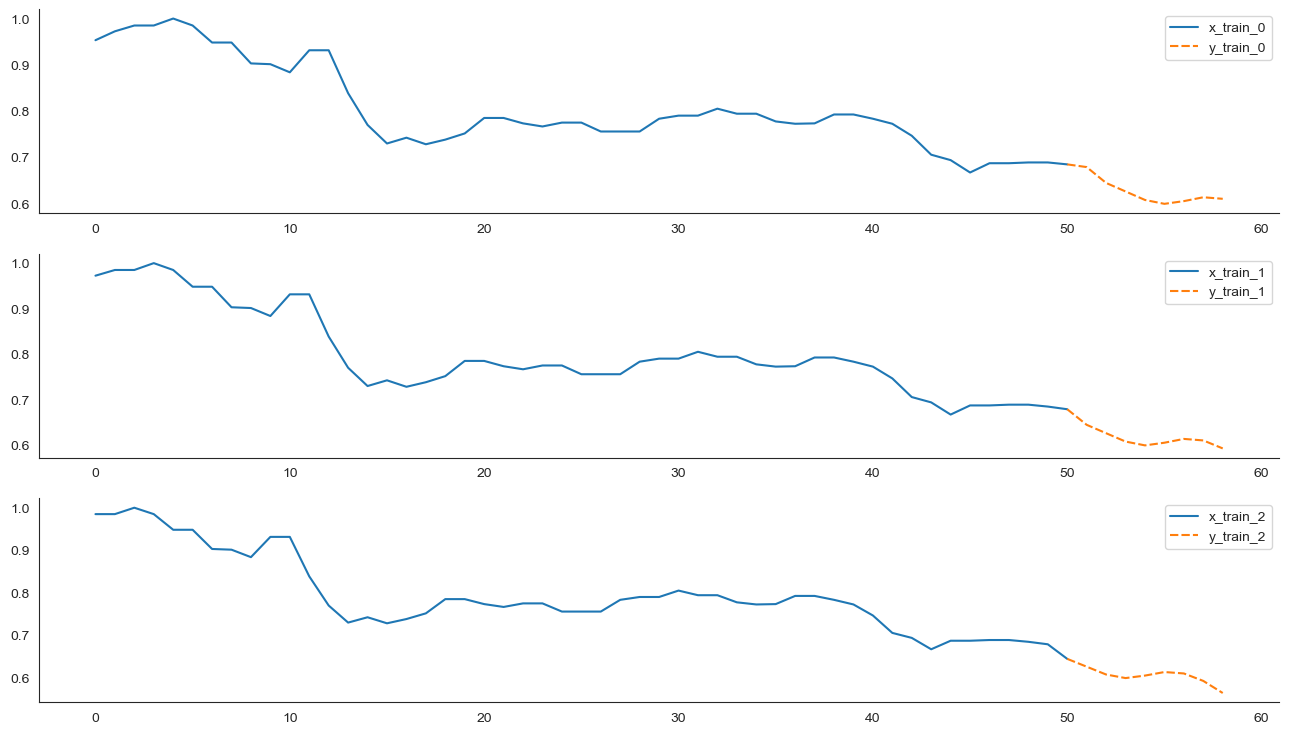

In [61]:
# Validating that the prediction value and the input match, last HPI_guelph_ont price of the second input must equal the first prediction value

nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1, figsize=(16,9))
for i, ax in enumerate(fig.axes):
    xtrain = pd.DataFrame(x_train[i][:, index_Close], columns={f'x_train_{i}'})
    ytrain = pd.DataFrame(y_train[i][:output_sequence_length - 1], columns = {f'y_train_{i}'})
    ytrain.index = np.arange(input_sequence_length, input_sequence_length + output_sequence_length - 1)
    xtrain = pd.concat([xtrain, ytrain[:1].rename(columns={ytrain.columns[0]:xtrain.columns[0]})])
    df_merge = pd.concat([xtrain, ytrain])
    sns.lineplot(data =  df_merge, ax = ax)
plt.show()

In [65]:
# Preparing Neural Network Architecture before training regression model for multi-output

model = Sequential()
n_output_neurons = output_sequence_length

n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences= True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_input_neurons, return_sequences= False))
model.add(Dense(20))
model.add(Dense(n_output_neurons))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mse')

1050 50 21


In [66]:
# Model training

epochs = 10 
batch_size = 64
early_stop = EarlyStopping(monitor = 'loss', patience = 5, verbose = 1)
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (x_test, y_test))

Epoch 1/10
4/6 [===================>..........] - ETA: 14s - loss: 0.2696

In [ ]:
import pickle

# save the model to disk
filename = 'canada_hpi_model.sav'
pickle.dump(model, open(filename, 'wb'))